# Project: Exploration and analysis Airbnb data of Madrid
Author: Luis Carrascosa Cabrera

# Analysing Airbnb data with pandas and plotly


## Introduction
Airbnb is the world’s biggest accommodation-sharing site. Its rapid growth and impact on vacation rentals has generated heated discussions about its effect in several of the world's largest cities. So much that regulations have emerged against the free use of this website:

* Amsterdam: the rental of complete houses is limited to 60 days a year and this will be reduced by half
* Barcelona: short-term rentals must have a license and new licenses are not being issued
* Berlin: owners need a permission to rent 50% or more of their main residence for a short period of time
* London: short-term rentals of entire houses are restricted to 90 days a year
* Palma: the mayor has announced the ban on short-term rentals
* New York: It is usually illegal to rent apartments for 30 consecutive days or less, unless the host is present
* Paris: short-term rentals are limited to 120 days a year
* San Francisco: hosts must register as a company and obtain certificates for short-term rental. The rental of entire properties is limited to 90 days a year
* Singapore: the minimum period of public housing rental is six consecutive months
* Tokyo: home sharing was legalized only in 2017 and is limited to 180 days a year
<div style="text-align: right"><i>Source: https://www.bbc.com/mundo/noticias-45355426</i></div>


Given the [Airbnb dataset of Madrid](http://insideairbnb.com/get-the-data.html), we propose to obtain the following information:

* Which areas have the most Airbnb properties, and which are the most expensive?
* Which amenities increase the price of an Airbnb listing?
* Influence of host features

## Version control
I will use numpy, pandas and plotly for the visualization. It's necessary a free mapbox account for drawing maps with plotly

In [49]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime
from scipy import stats
from plotly.subplots import make_subplots
%matplotlib inline

In [50]:
mapbox_token_folder = "/home/luis/Documentos/mapbox"
mapbox_access_token = open(f"{mapbox_token_folder}/token").read()
px.set_mapbox_access_token(mapbox_access_token)

### Version control

In [51]:
import subprocess, sys

def getVersion(libs):
    print(sys.version)
    
    for lib in libs:  
        lib_version = str(subprocess.run([
            sys.executable, '-m', 'pip', 'show', f'{lib}'
        ], capture_output=True, text=True))

        print('{0:15}  {1}'.format(lib, lib_version.split("\\n")[1]))

getVersion(['numpy', 'pandas', 'geopandas', 'matplotlib', 'plotly', 'scipy'])

3.8.1 (default, Dec 31 2019, 18:42:42) 
[GCC 7.4.0]
numpy            Version: 1.18.1
pandas           Version: 0.25.3
geopandas        Version: 0.6.2
matplotlib       Version: 3.1.2
plotly           Version: 4.4.1
scipy            Version: 1.4.1


## Processing the data
### Import the data

The dataset used for this project comes from Insideairbnb.com. The dataset was scraped on 2019-11-09 and contains information on all Madrid Airbnb listings that were live on the site on that date (20.539)

I will not import free text fields and I will remove the currency symbol from fields with amounts. "smart_location", "zipcode" are redundant having latitude and longitude. "reviews_per_month", "number_of_reviews_ltm" with "number_of_reviews" too. url fields does not add value to the model. I don't import "host_name", "host_location" and "host_about" too. We will not keep any of the host count columns:

In [52]:
datasetDir = "./dataset"

import locale
locale.setlocale(locale.LC_ALL, 'en_US.UTF8') 
conv = locale.localeconv()

fconv_prices = lambda x : locale.atof(x.strip(conv['currency_symbol'])) if x else np.nan 

def fdate_parser(x, dtime_format = "%d-%m-%Y"):
    return datetime.strptime(x, dtime_format) 

In [53]:
df = pd.read_csv(
    f'{datasetDir}/listings_detailed.csv', 
    sep = ',', 
    index_col = 'id', 
    converters = {
        'price': fconv_prices, 
        'weekly_price': fconv_prices, 
        'monthly_price': fconv_prices,
        'security_deposit': fconv_prices,
        'cleaning_fee': fconv_prices,
        'extra_people': fconv_prices
    },
    parse_dates = ['first_review', 'last_review'],
    usecols = lambda column : column not in [
        'zipcode', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 
        'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 
        'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_url', 'host_name', 
        'host_location', 'host_about', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 
        'host_verifications', 'calendar_last_scraped', 'listing_url', 'smart_location', 'reviews_per_month', 
        'number_of_reviews_ltm', 'host_id', 'host_total_listings_count', 'calculated_host_listings_count', 
        'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 
        'calculated_host_listings_count_shared_rooms', 'host_listings_count', 'host_since'
    ]
)

df.head(3)

experiences_offered  host_response_time host_response_rate  \
id                                                                 
6369                 none  within a few hours               100%   
21853                none                 NaN                NaN   
23001                none      within an hour               100%   

       host_acceptance_rate host_is_superhost host_has_profile_pic  \
id                                                                   
6369                    NaN                 f                    t   
21853                   NaN                 f                    t   
23001                   NaN                 f                    t   

      host_identity_verified                              street  \
id                                                                 
6369                       f  Madrid, Comunidad de Madrid, Spain   
21853                      t               Madrid, Madrid, Spain   
23001                      f  Madrid, Comunidad de Madrid, Spain   

      neighbourhood neighbourhood_cleansed  ... review_scores_location  \
id                                          ...                          
6369      Chamartín         Hispanoamérica  ...                    9.0   
21853        Aluche               Cármenes  ...                    8.0   
23001       Legazpi                Legazpi  ...                    NaN   

      review_scores_value requires_license license jurisdiction_names  \
id                                                                      
6369                 10.0                t     NaN                NaN   
21853                 9.0                t     NaN                NaN   
23001                 NaN                t     NaN                NaN   

      instant_bookable  is_business_travel_ready          cancellation_policy  \
id                                                                              
6369                 f                         f                     flexible   
21853                f                         f  strict_14_with_grace_period   
23001                f                         f                     moderate   

      require_guest_profile_picture require_guest_phone_verification  
id                                                                    
6369                              f                                f  
21853                             f                                f  
23001                             f                                f  

[3 rows x 67 columns]

### Cleaning the features

I will drop columns with more than 85% nulls

In [54]:
cols_to_drop = set(df.columns[df.isna().mean()>0.85])
print(cols_to_drop)

{'jurisdiction_names', 'square_feet', 'weekly_price', 'host_acceptance_rate', 'monthly_price'}


In [55]:
df.drop(cols_to_drop, axis='columns', inplace=True)

We only use latitude, longitude and neighbourhood_cleansed location. As we are studying Madrid, the city and country columns do not contribute

In [56]:
df_gps = df[['latitude', 'longitude']]
df_gps.head()

latitude  longitude
id                        
6369   40.45628   -3.67763
21853  40.40341   -3.74084
23001  40.38695   -3.69304
24805  40.42202   -3.70395
24836  40.41995   -3.69764

In [57]:
df.drop(
    ['neighbourhood', 'neighbourhood_group_cleansed', 'street', 'city', 'state', 'country', 
     'country_code', 'is_location_exact', 'latitude', 'longitude']
    , axis='columns', inplace=True
)

For the number of nights we will only leave "minimum_nights" and "maximum_nights"

In [58]:
df.drop(
    ['minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 
     'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm']
    , axis='columns', inplace=True
)

We will change the price column for the price per guest

In [59]:
df['B_price_guests'] = df['price']/df['guests_included']

df.drop(['price'], axis='columns', inplace=True)
df['B_price_guests'].head()

id
6369     35.00
21853    17.00
23001    60.00
24805    40.00
24836    28.75
Name: B_price_guests, dtype: float64

In [60]:
df[['B_price_guests']].head()

B_price_guests
id                   
6369            35.00
21853           17.00
23001           60.00
24805           40.00
24836           28.75

We'll eliminate prices per guest above quantile 95. Thus we will eliminate possible artificially high prices due to the effect of smart pricing

In [61]:
outliers = list(df[df['B_price_guests'] >= df['B_price_guests'].quantile(.95)].index)
print(len(outliers))

1087


In [62]:
df_rev = df.drop(outliers, axis='rows', inplace=False)

box1 = go.Box(y=df['B_price_guests'])
box2 = go.Box(y=df_rev['B_price_guests'])

fig = make_subplots(rows=1, cols=2, subplot_titles=("Original", "95% outliers removal"))
fig.add_trace(box1, row=1, col=1)
fig.add_trace(box2, row=1, col=2)
fig.update_layout(showlegend=False)

fig.show()

Thus we eliminate prices per guest that exceed 5000 and even reach 9000 dollars. Let's compare prices per guest in both dataset

In [63]:
plotData1 = go.Scatter(
    x=df.index, y=df['B_price_guests'], 
    mode='markers',
    marker=dict(
        color='LightSkyBlue',
        size=2
    )
)

plotData2 = go.Scatter(
    x=df_rev.index, y=df_rev['B_price_guests'], 
    mode='markers',
    marker=dict(
        color='LightSkyBlue',
        size=2
    )
)

layout = go.Layout(
    title={'x': 0.5},
    xaxis={'title': 'id'},
    yaxis={'title': 'B_price_guests'},
    margin=go.layout.Margin(l=0, r=0, t=0, b=0)
)

fig = make_subplots(rows=2, cols=1, subplot_titles=("Madrid airbnb data", 
                                                    "Madrid airbnb data without 95% outliers"))
fig.add_trace(plotData1, row=1, col=1)
fig.add_trace(plotData2, row=2, col=1)
fig.update_layout(showlegend=False)

fig.update_layout(title_text='Price per guest')

fig.show()

We don't lose the two concentrations near the ids 20M and 35M.
<br>Let's represent each column to review them

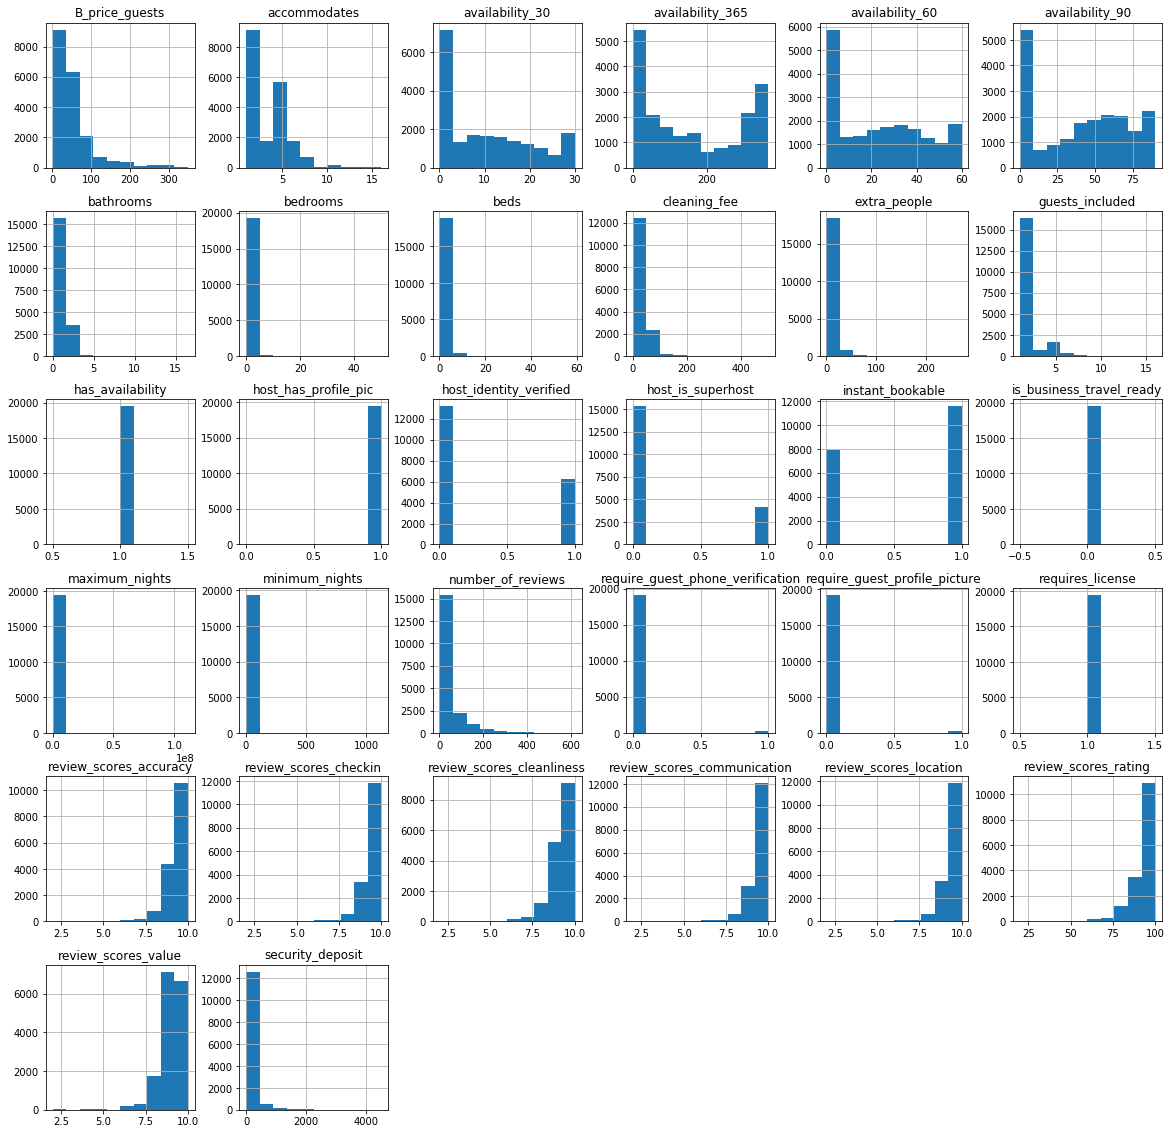

In [64]:
df_temp = df_rev.replace({'f': 0, 't': 1}, inplace=False)
df_temp.hist(figsize=(20,20));

Columns with only one category are deleted

In [65]:
df_rev.drop(['has_availability', 'host_has_profile_pic', 'is_business_travel_ready', 'require_guest_phone_verification', 
 'require_guest_profile_picture', 'requires_license'], 
        axis='columns', inplace=True)

## Answering questions
* Which areas have the most Airbnb properties, and which are the most expensive?
<br> We need the gps coordinates

In [66]:
df_full_map = df_gps.copy().join(df_rev.loc[:, ['B_price_guests', 'neighbourhood_cleansed']], on = 'id', how = 'inner')
df_full_map.head()

latitude  longitude  B_price_guests neighbourhood_cleansed
id                                                               
6369   40.45628   -3.67763           35.00         Hispanoamérica
21853  40.40341   -3.74084           17.00               Cármenes
23001  40.38695   -3.69304           60.00                Legazpi
24805  40.42202   -3.70395           40.00            Universidad
24836  40.41995   -3.69764           28.75               Justicia

In [67]:
fig = px.scatter_mapbox(
    df_full_map, lat = "latitude", lon = "longitude",
    color = "B_price_guests", color_continuous_scale = px.colors.cyclical.IceFire,
    zoom = 10
)

fig.update_layout(
    margin=dict(l=0, r=0, t=0, b=0),
    showlegend=True,
    autosize=True
)

fig.show()

We need to import the geojson data file and get the representatives points to annotate in the map

In [68]:
df_madrid_map = gpd.read_file(f'{datasetDir}/neighbourhoods.geojson')
crs = {"init": "epsg:4326"}  

df_madrid_map = df_madrid_map.rename(columns={"neighbourhood": "neighbourhood_cleansed"})
df_madrid_map = df_madrid_map.set_index('neighbourhood_cleansed')
df_madrid_map = df_madrid_map.drop('neighbourhood_group', axis=1)

df_madrid_map['rep_point'] = df_madrid_map.geometry.apply(lambda x: x.representative_point().coords[:][0])

We group by "neighbourhood_cleansed" and we generate a GeoDataFrame to draw a color map (I can't do it with Plotly)

In [69]:
df_agg_neighbourhood = df_full_map.groupby('neighbourhood_cleansed').size().to_frame()
df_agg_neighbourhood.rename(columns={0: 'number_of_listings'}, inplace=True)
df_agg_neighbourhood['median_price'] = df_full_map.groupby('neighbourhood_cleansed').B_price_guests.median().values
df_agg_neighbourhood['mean_price'] = round(df_full_map.groupby('neighbourhood_cleansed').B_price_guests.mean(), 2).values

geo_df_agg_neighbourhood = gpd.GeoDataFrame(
    df_agg_neighbourhood.join(df_madrid_map, on = 'neighbourhood_cleansed', how = 'inner'), 
    crs = crs
) 

geo_df_agg_neighbourhood.sort_values(by='number_of_listings')

number_of_listings  median_price  mean_price  \
neighbourhood_cleansed                                                 
Horcajo                                  1         30.00       30.00   
El Pardo                                 2         33.00       33.00   
Fuentelareina                            3         20.00       46.67   
Valdemarín                               5         60.00       80.00   
El Plantío                               5         32.25       39.83   
...                                    ...           ...         ...   
Justicia                              1138         45.00       62.07   
Sol                                   1309         45.00       59.33   
Palacio                               1467         40.00       56.90   
Universidad                           1911         45.00       57.63   
Embajadores                           2629         35.00       48.29   

                                                                 geometry  \
neighbourhood_cleansed                                                      
Horcajo                 MULTIPOLYGON (((-3.62172 40.41308, -3.62128 40...   
El Pardo                MULTIPOLYGON (((-3.65273 40.64275, -3.65250 40...   
Fuentelareina           MULTIPOLYGON (((-3.73742 40.48957, -3.73707 40...   
Valdemarín              MULTIPOLYGON (((-3.76259 40.46143, -3.76266 40...   
El Plantío              MULTIPOLYGON (((-3.83804 40.47093, -3.83744 40...   
...                                                                   ...   
Justicia                MULTIPOLYGON (((-3.69546 40.41898, -3.69645 40...   
Sol                     MULTIPOLYGON (((-3.70475 40.42027, -3.70150 40...   
Palacio                 MULTIPOLYGON (((-3.70584 40.42030, -3.70625 40...   
Universidad             MULTIPOLYGON (((-3.70107 40.42134, -3.70155 40...   
Embajadores             MULTIPOLYGON (((-3.70384 40.41432, -3.70277 40...   

                                                        rep_point  
neighbourhood_cleansed                                             
Horcajo                          (-3.6267397880355574, 40.408416)  
El Pardo                         (-3.793460996281465, 40.5562945)  
Fuentelareina                     (-3.739902266262524, 40.480324)  
Valdemarín                       (-3.782542982189973, 40.4681135)  
El Plantío                       (-3.8193116622862573, 40.469333)  
...                                                           ...  
Justicia                (-3.6957165641654988, 40.423874999999995)  
Sol                               (-3.7043801662531006, 40.41691)  
Palacio                          (-3.7155012056631884, 40.415026)  
Universidad                      (-3.7065535733753014, 40.425296)  
Embajadores                      (-3.7013581944266445, 40.409564)  

[127 rows x 5 columns]

We define a function and plot number of listings, median and mean
### Listings number

In [70]:
def region_plot(df_plot, column, rep_point_col = 'rep_point', titleName = '', legend_label = '', 
                fontsize=10, annonations = False, aspect = 1., figsize=(25, 25), dpi = 100):
    fig, ax = plt.subplots(figsize=figsize, dpi = dpi)

    df_plot.plot(
        alpha = 1, cmap='Blues', edgecolor = "black", ax = ax, 
        column=column,
        legend=True,
        legend_kwds={'label': legend_label, 'orientation': "vertical"}
    )

    if annonations != False:
        for idx, row in df_plot.iterrows():
            ax.annotate(
                s=idx, 
                xy=row[rep_point_col],
                horizontalalignment='center'
            )
        
    ax.axis('off')
    ax.set_title(titleName, fontsize=fontsize)

    ax.set_aspect(aspect=aspect)
    ax.margins(0)
    ax.apply_aspect()
    
    plt.show()

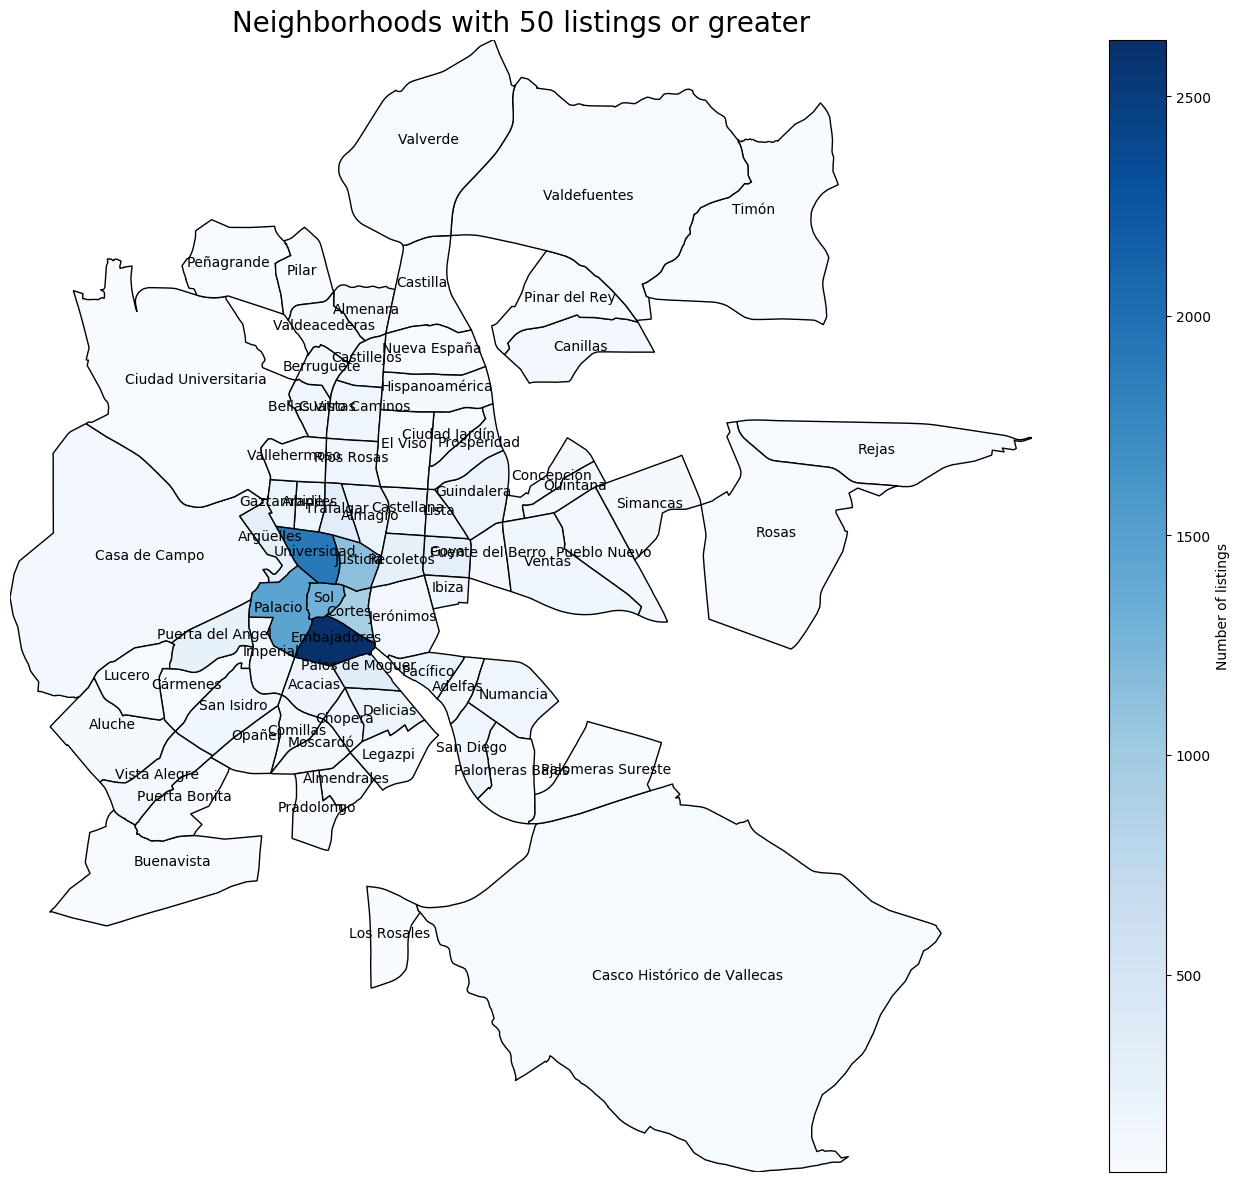

In [71]:
region_plot(
    geo_df_agg_neighbourhood[geo_df_agg_neighbourhood['number_of_listings']>50], 
    column = 'number_of_listings', titleName = 'Neighborhoods with 50 listings or greater', 
    fontsize=20, annonations = True, aspect=4./3, legend_label = 'Number of listings', figsize=(20, 15))

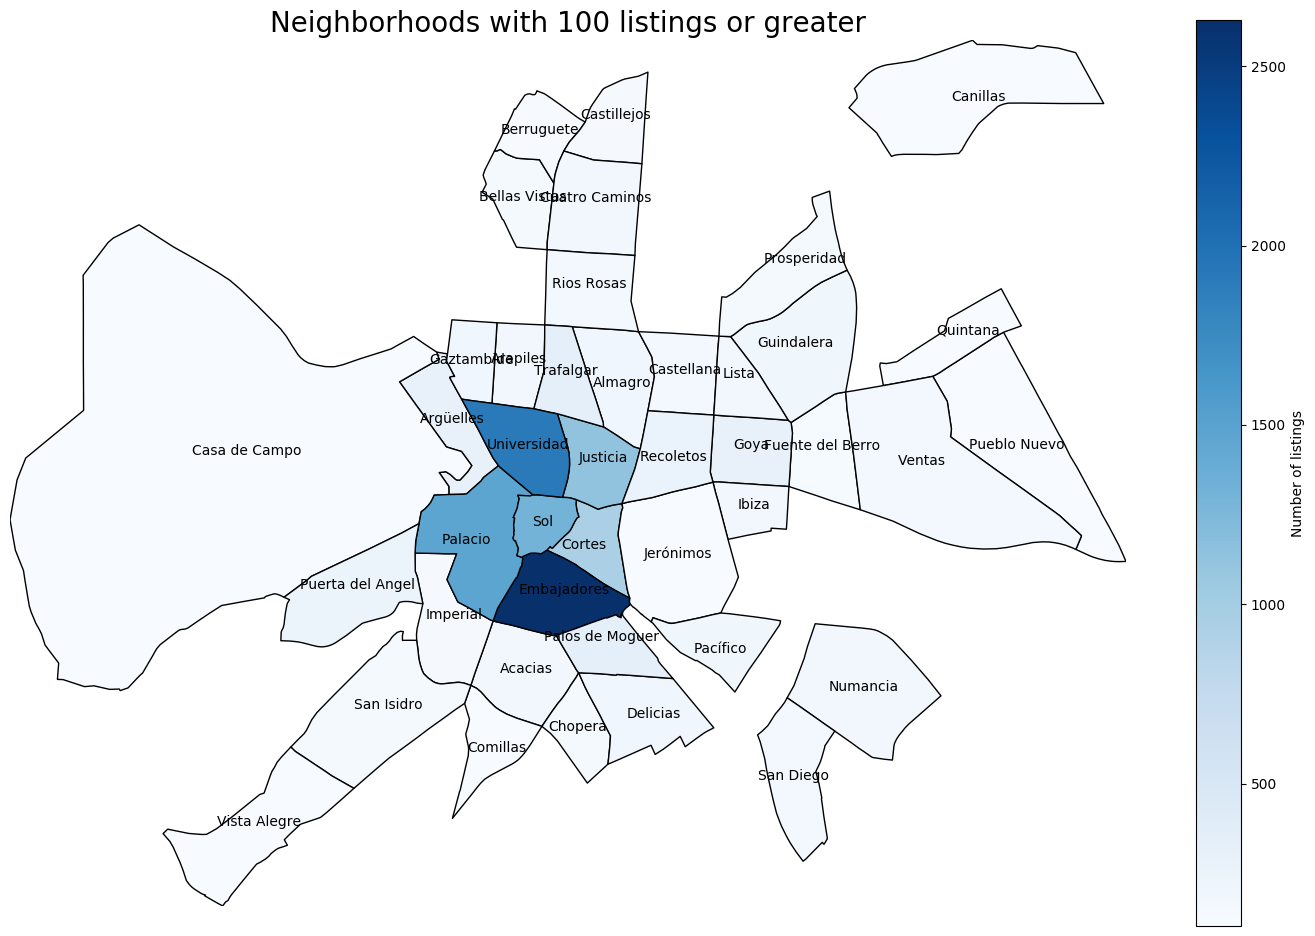

In [72]:
region_plot(
    geo_df_agg_neighbourhood[geo_df_agg_neighbourhood['number_of_listings']>100], 
    column = 'number_of_listings', titleName = 'Neighborhoods with 100 listings or greater', 
    fontsize=20, annonations = True, aspect = 4./3, legend_label = 'Number of listings', figsize=(18, 12)
)

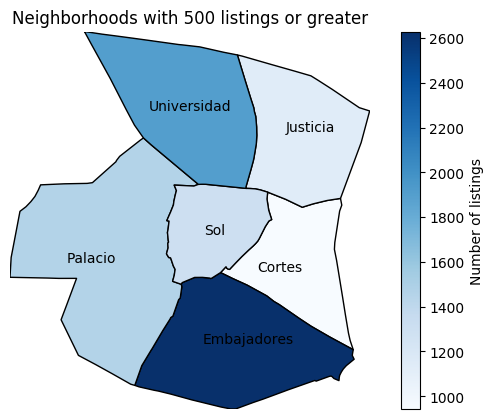

In [73]:
region_plot(
    geo_df_agg_neighbourhood[geo_df_agg_neighbourhood['number_of_listings']>500], 
    column = 'number_of_listings', titleName = 'Neighborhoods with 500 listings or greater', 
    fontsize=12, annonations = True, aspect = 4./3, legend_label = 'Number of listings', figsize=(8, 5)
)

In [74]:
geo_df_agg_neighbourhood[geo_df_agg_neighbourhood['number_of_listings']>500][['number_of_listings', 'median_price']]

number_of_listings  median_price
neighbourhood_cleansed                                  
Cortes                                 943          39.0
Embajadores                           2629          35.0
Justicia                              1138          45.0
Palacio                               1467          40.0
Sol                                   1309          45.0
Universidad                           1911          45.0

The largest number of houses is in the center
### Price per guest included
<br> Mean or median? There are listings with a high price and only one guest included, but its "accomodates" is high. Let's use median to soften those anomalies

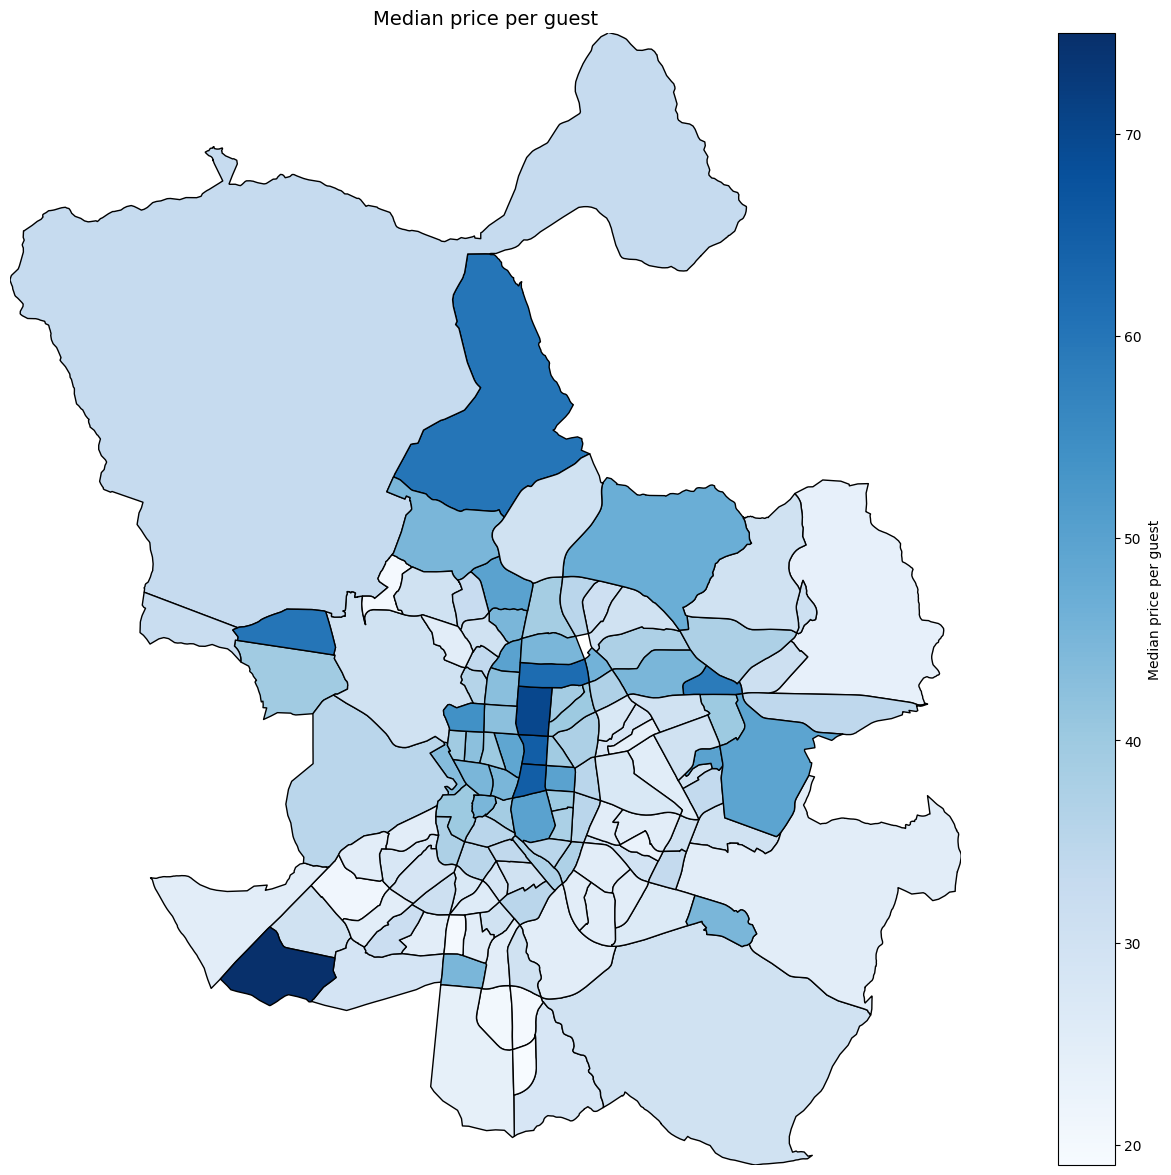

In [75]:
region_plot(
    geo_df_agg_neighbourhood, 
    column = 'median_price', titleName = 'Median price per guest', 
    fontsize=14, annonations = False, aspect = 4./3, legend_label = 'Median price per guest', figsize=(25, 15)
)

There are peripheral areas with a high median. Let's filter by min 50$

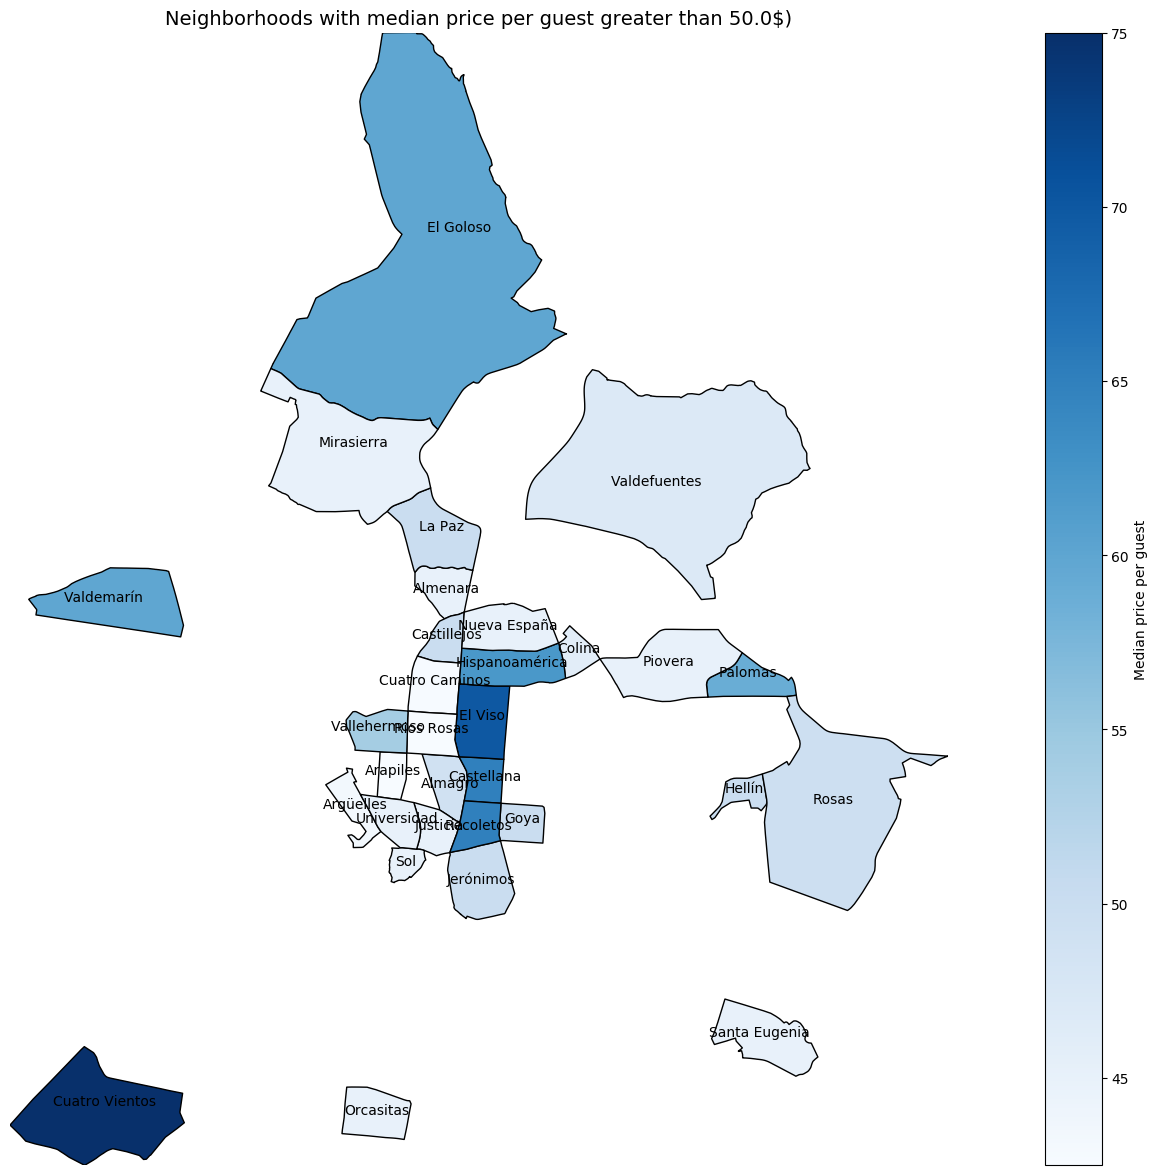

In [76]:
region_plot(
    geo_df_agg_neighbourhood[geo_df_agg_neighbourhood['median_price']>40.], 
    column = 'median_price', titleName = 'Neighborhoods with median price per guest greater than 50.0$)', 
    fontsize=14, annonations = True, aspect = 4./3, legend_label = 'Median price per guest', figsize=(25, 15)
)

In [77]:
geo_df_agg_neighbourhood[geo_df_agg_neighbourhood['median_price']>50][['number_of_listings', 'median_price']]

number_of_listings  median_price
neighbourhood_cleansed                                  
Castellana                             168          65.0
Cuatro Vientos                           7          75.0
El Goloso                               11          60.0
El Viso                                 71          70.0
Hispanoamérica                         100          62.0
Palomas                                 17          59.0
Recoletos                              274          65.0
Valdemarín                               5          60.0
Vallehermoso                            57          54.0

The areas with the highest median price are no longer all concentrated in the city center. The "Cuatro Vientos" area is notable, surely there is a high demand due to the air base sited there. However it has little offer, which would explain these high prices

In [78]:
df_full_map[df_full_map.neighbourhood_cleansed == 'Cuatro Vientos']

latitude  longitude  B_price_guests neighbourhood_cleansed
id                                                                  
20324976  40.37025   -3.77034            75.0         Cuatro Vientos
30261870  40.36806   -3.76347            15.0         Cuatro Vientos
33801693  40.37194   -3.77140            55.0         Cuatro Vientos
35125746  40.36734   -3.76397            17.0         Cuatro Vientos
35157642  40.36698   -3.76177           250.0         Cuatro Vientos
35184131  40.36721   -3.76252           200.0         Cuatro Vientos
36707244  40.37160   -3.76639           100.0         Cuatro Vientos

## Which amenities increase the price of an Airbnb listing?
We will draw a barchart for every amenity group to compare number of listings versus median price.

**amenities**
<br>Additional features in the property, e.g. whether it has a TV or parking. This data is a list and we need to extract a list of all posibles amenities 

In [79]:
amenities_list = set()
for index, value in df_rev.amenities.items():
    value = value.replace('{', '').replace('"', '').replace('}', '')
    amenities_list = amenities_list.union(set(value.split(sep=',')))
    
print(amenities_list)

{'', 'Air conditioning', 'Carbon monoxide detector', 'Memory foam mattress', 'Cooking basics', 'Cat(s)', 'Hair dryer', 'EV charger', 'Wifi', 'Walk-in shower', 'Indoor fireplace', 'Table corner guards', 'Heated towel rack', 'Changing table', 'Babysitter recommendations', 'Single level home', 'Lockbox', 'Full kitchen', ' toilet', 'Shared pool', 'Fire extinguisher', 'High chair', 'Pool with pool hoist', 'Room-darkening shades', 'Kitchenette', 'Dog(s)', 'Extra space around bed', 'Mudroom', 'First aid kit', 'Private living room', 'Safety card', 'Touchless faucets', 'Wide hallways', 'Wide doorway to guest bathroom', 'Accessible-height toilet', 'Sound system', 'Wide clearance to shower', 'Netflix', 'Bathtub', 'Smoke detector', 'Iron', 'Patio or balcony', 'Body soap', 'Toilet paper', 'Convection oven', 'Wide entrance', 'Smart TV', 'Terrace', 'Kitchen', 'Mini fridge', 'Luggage dropoff allowed', 'Heated floors', 'Pool', 'Refrigerator', 'Breakfast', 'Ceiling fan', 'Cable TV', 'Hammock', 'Hangers'

I define the following groupings of amenities:

In [80]:
amenities_regexprs = [
r'(?P<B_amenities_pets>Pets allowed|Other pet|Dog|Cat|Pets live on this property)',
r'(?P<B_amenities_kitchen>Kitchen|Kitchenette|Full kitchen)',
r'(?P<B_amenities_high_kitchen>Warming drawer|Wine cooler|Steam oven|Double oven)',
r'(?P<B_amenities_high_bedroom>Firm mattress|Memory foam mattress|Pillow-top mattress)',
r'(?P<B_amenities_outdoor>BBQ grill|Terrace|Outdoor seating|Patio or balcony|Hammock|Garden or backyard|Balcony|Sun loungers)',
r'(?P<B_amenities_family_friendly>Family\/kid friendly|Changing table|Baby bath|Crib|Children’s books and toys|Pack ’n Play\/travel crib|Fireplace guards|Babysitter recommendations|Window guards|Children’s dinnerware|Stair gates|Table corner guards|Outlet covers|Baby monitor|High chair)',
r'(?P<B_amenities_home_appliances>Washer \/ Dryer|Refrigerator|Mini fridge|Gas oven|Cooking basics|Dryer|Convection oven|Microwave|Washer|Oven|Dishes and silverware|Iron|Dishwasher)',
r'(?P<B_amenities_high_electronics>HBO GO|Smart TV|Netflix|Projector and screen|Game console|Amazon Echo)',
r'(?P<B_amenities_normal_electronics>DVD player|Printer|TV|Cable TV|Sound system|High-resolution computer monitor)',
r'(?P<B_amenities_special_accessibility>Fixed grab bars for shower|Accessible-height bed|Extra space around bed|Pool with pool hoist|Electric profiling bed|Accessible-height toilet|Wide doorway to guest bathroom|Ground floor access|Single level home|Wheelchair accessible|Disabled parking spot|Shower chair|No stairs or steps to enter|Step-free shower|Bathtub with bath chair|Wide entrance|Fixed grab bars for toilet|Wide entrance for guests|Flat path to guest entrance|Mobile hoist|Wide clearance to shower|Wide hallways|Wide entryway)',
r'(?P<B_amenities_breakfast_appliances>Espresso machine|Hot water kettle|Coffee maker)',
r'(?P<B_amenities_gym>Gym|Exercise equipment)',
r'(?P<B_amenities_pool>Shared pool|Pool)',
r'(?P<B_amenities_heating>Heated towel rack|Heating|Heated floors|Stove)',
r'(?P<B_amenities_other>Other|Essentials|Breakfast table|Beach essentials|Buzzer\/wireless intercom|Formal dining area|Ceiling fan|Day bed|Room-darkening shades|Laptop friendly workspace|Standing valet)',
r'(?P<B_amenities_views>Beach view|Ski-in/Ski-out|Waterfront|Beachfront|Beachfront)',
r'(?P<B_amenities_internet>Ethernet connection|Wifi|Pocket wifi|Internet)',
r'(?P<B_amenities_bathroom_basics>Hot water|Walk-in shower|Bathtu|Soaking tub|Handheld shower head|Bath towel|Bidet|Shampoo|Rain shower|Body soap|toilet|Bathroom essentials|Toilet paper|Hair dryer)',
r'(?P<B_amenities_cleaning_before_checkout>Cleaning before checkout)',
r'(?P<B_amenities_bedroom_basics>Bedroom comforts|Extra pillows and blankets|Bed linens|Hangers)',
r'(?P<B_amenities_security>Lockbox|Lock on bedroom door)',
r'(?P<B_amenities_indoor_fireplace>Indoor fireplace)',
r'(?P<B_amenities_staff>Building staff|Doorman)',
r'(?P<B_amenities_smoking>Smoking allowed)',
r'(?P<B_amenities_high_bathroom>Jetted tub|Touchless faucets|Hot tub)',    
r'(?P<B_amenities_proximity_host>Host greets you)',
r'(?P<B_amenities_general_accesibility>Well-lit path to entrance|Elevator)',
r'(?P<B_amenities_free_parking>Free street parking|Free parking on premises)',  
r'(?P<B_amenities_paid_parking>Paid parking on premises|Paid parking off premises)',
r'(?P<B_amenities_air_conditioning>Central air conditioning|Air conditioning)',
r'(?P<B_amenities_privacy>Private living room|Private bathroom|Private entrance|En suite bathroom)',
r'(?P<B_amenities_safety>Fire extinguisher|Carbon monoxide detector|Smoke detector|Safety card|First aid kit)',
r'(?P<B_amenities_luggage>Mudroom|Luggage dropoff allowed)',    
r'(?P<B_amenities_ev_charger>EV charger)',     
r'(?P<B_amenities_breakfast>Breakfast)',
r'(?P<B_amenities_self_check>Keypad|24-hour check-in|Self check-in|Smart lock)',    
r'(?P<B_amenities_suitable_events>Suitable for events)',
r'(?P<B_amenities_long_term>Long term stays allowed)'   
]

Iterating through the list of regular expressions we will build a dataframe with the groups of defined things that we will add to obtain the totals of each group. These regular expressions could be concatenated to obtain such dataframe but in this way pandas does not find all the matches

In [81]:
def_amenities = df_rev.amenities.str.extract(amenities_regexprs[0], expand=True)

for reg_expr in amenities_regexprs[1:]:
    col_name = reg_expr.split('<')[1].split('>')[0]
    def_amenities[col_name] = df_rev.amenities.str.extract(reg_expr, expand=False)
    
serie_amenities = def_amenities.notna().sum()/len(df_rev)*100.0
round(serie_amenities, 2)

B_amenities_pets                        14.89
B_amenities_kitchen                     91.07
B_amenities_high_kitchen                 0.07
B_amenities_high_bedroom                 0.18
B_amenities_outdoor                     15.27
B_amenities_family_friendly             39.76
B_amenities_home_appliances             93.48
B_amenities_high_electronics             0.83
B_amenities_normal_electronics          79.96
B_amenities_special_accessibility       21.91
B_amenities_breakfast_appliances        41.91
B_amenities_gym                          1.67
B_amenities_pool                         4.01
B_amenities_heating                     90.12
B_amenities_other                       96.69
B_amenities_views                        0.78
B_amenities_internet                    95.81
B_amenities_bathroom_basics             92.87
B_amenities_cleaning_before_checkout     2.87
B_amenities_bedroom_basics              85.69
B_amenities_security                    16.92
B_amenities_indoor_fireplace      

We will remove those that offer more than 90% of ads and those that are below 10%

In [82]:
low_frequent_cols = list(serie_amenities[serie_amenities<10.0].index)
high_frequent_cols = list(serie_amenities[serie_amenities>90.0].index)

def_amenities.drop(low_frequent_cols, axis=1, inplace=True)
def_amenities.drop(high_frequent_cols, axis=1, inplace=True)

print(f"high_frequent_cols: {high_frequent_cols}\n\nlow_frequent_cols: {low_frequent_cols}")

high_frequent_cols: ['B_amenities_kitchen', 'B_amenities_home_appliances', 'B_amenities_heating', 'B_amenities_other', 'B_amenities_internet', 'B_amenities_bathroom_basics']

low_frequent_cols: ['B_amenities_high_kitchen', 'B_amenities_high_bedroom', 'B_amenities_high_electronics', 'B_amenities_gym', 'B_amenities_pool', 'B_amenities_views', 'B_amenities_cleaning_before_checkout', 'B_amenities_indoor_fireplace', 'B_amenities_staff', 'B_amenities_high_bathroom', 'B_amenities_ev_charger', 'B_amenities_suitable_events']


In [83]:
round(def_amenities.notna().sum()/len(df_rev)*100.0, 2)

B_amenities_pets                     14.89
B_amenities_outdoor                  15.27
B_amenities_family_friendly          39.76
B_amenities_normal_electronics       79.96
B_amenities_special_accessibility    21.91
B_amenities_breakfast_appliances     41.91
B_amenities_bedroom_basics           85.69
B_amenities_security                 16.92
B_amenities_smoking                  20.98
B_amenities_proximity_host           35.31
B_amenities_general_accesibility     61.43
B_amenities_free_parking             16.26
B_amenities_paid_parking             31.89
B_amenities_air_conditioning         63.65
B_amenities_privacy                  21.67
B_amenities_safety                   45.13
B_amenities_luggage                  19.00
B_amenities_breakfast                11.89
B_amenities_self_check               14.78
B_amenities_long_term                29.51
dtype: float64

If it is null we change it to an "f". If it is not for a "t"

In [84]:
for col in list(def_amenities.columns):
    def_amenities.loc[def_amenities[col].notna(), col] = 't'
    def_amenities.loc[def_amenities[col].isna(), col] = 'f'
    
def_amenities.head()

B_amenities_pets B_amenities_outdoor B_amenities_family_friendly  \
id                                                                       
6369                 f                   f                           t   
21853                f                   f                           f   
23001                f                   f                           t   
24805                f                   f                           t   
24836                f                   f                           t   

      B_amenities_normal_electronics B_amenities_special_accessibility  \
id                                                                       
6369                               f                                 f   
21853                              t                                 f   
23001                              t                                 t   
24805                              t                                 f   
24836                              t                                 f   

      B_amenities_breakfast_appliances B_amenities_bedroom_basics  \
id                                                                  
6369                                 f                          t   
21853                                t                          t   
23001                                t                          t   
24805                                t                          t   
24836                                f                          t   

      B_amenities_security B_amenities_smoking B_amenities_proximity_host  \
id                                                                          
6369                     f                   f                          f   
21853                    t                   f                          f   
23001                    t                   t                          f   
24805                    f                   f                          t   
24836                    f                   f                          t   

      B_amenities_general_accesibility B_amenities_free_parking  \
id                                                                
6369                                 t                        f   
21853                                t                        t   
23001                                t                        f   
24805                                t                        f   
24836                                t                        f   

      B_amenities_paid_parking B_amenities_air_conditioning  \
id                                                            
6369                         f                            t   
21853                        f                            t   
23001                        t                            t   
24805                        t                            t   
24836                        t                            t   

      B_amenities_privacy B_amenities_safety B_amenities_luggage  \
id                                                                 
6369                    f                  f                   f   
21853                   f                  t                   f   
23001                   t                  f                   t   
24805                   f                  t                   t   
24836                   f                  f                   f   

      B_amenities_breakfast B_amenities_self_check B_amenities_long_term  
id                                                                        
6369                      f                      f                     f  
21853                     f                      f                     f  
23001                     f                      f                     t  
24805                     f                      t                     t  
24836                     f                      f                     f

Let's draw a histogram to see the columns we have obtained by extracting the information from "amenities"

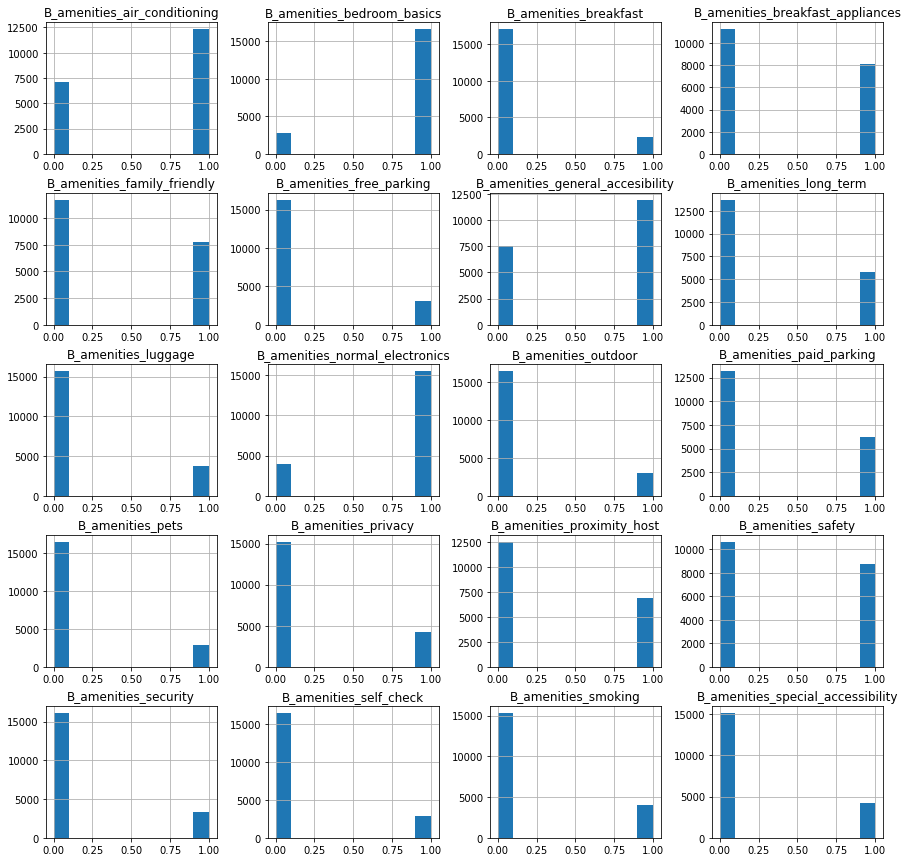

In [85]:
df_temp = def_amenities.replace({'f': 0, 't': 1}, inplace=False)
df_temp.hist(figsize=(15,15));

We join both dataframe and drop the "amenities" column

In [86]:
df_rev.drop(['amenities'], axis=1, inplace=True)
df_full = df_rev.join(def_amenities, on = 'id', how = 'inner')
df_full.head()

experiences_offered  host_response_time host_response_rate  \
id                                                                 
6369                 none  within a few hours               100%   
21853                none                 NaN                NaN   
23001                none      within an hour               100%   
24805                none  within a few hours               100%   
24836                none  within a few hours               100%   

      host_is_superhost host_identity_verified neighbourhood_cleansed  market  \
id                                                                              
6369                  f                      f         Hispanoamérica  Madrid   
21853                 f                      t               Cármenes  Madrid   
23001                 f                      f                Legazpi  Madrid   
24805                 f                      t            Universidad  Madrid   
24836                 t                      f               Justicia  Madrid   

      property_type        room_type  accommodates  ...  \
id                                                  ...   
6369      Apartment     Private room             2  ...   
21853     Apartment     Private room             1  ...   
23001     Apartment  Entire home/apt             6  ...   
24805     Apartment  Entire home/apt             3  ...   
24836     Apartment  Entire home/apt             4  ...   

       B_amenities_general_accesibility  B_amenities_free_parking  \
id                                                                  
6369                                  t                         f   
21853                                 t                         t   
23001                                 t                         f   
24805                                 t                         f   
24836                                 t                         f   

       B_amenities_paid_parking B_amenities_air_conditioning  \
id                                                             
6369                          f                            t   
21853                         f                            t   
23001                         t                            t   
24805                         t                            t   
24836                         t                            t   

       B_amenities_privacy  B_amenities_safety  B_amenities_luggage  \
id                                                                    
6369                     f                   f                    f   
21853                    f                   t                    f   
23001                    t                   f                    t   
24805                    f                   t                    t   
24836                    f                   f                    f   

       B_amenities_breakfast  B_amenities_self_check  B_amenities_long_term  
id                                                                           
6369                       f                       f                      f  
21853                      f                       f                      f  
23001                      f                       f                      t  
24805                      f                       t                      t  
24836                      f                       f                      f  

[5 rows x 59 columns]

In [87]:
dict_amenities = {
    x:x.replace('B_amenities_', '').replace('_', ' ').upper() 
    for x in df_full.filter(like='B_amenities_').columns.to_list()
}

def plot_barchart(df, dict_columns = dict_amenities, width=800, height=300):   
    for col in list(dict_columns):
        s_1 = df.groupby(col).size()
        s_2 = df.groupby(col)['B_price_guests'].median()

        fig = make_subplots(rows=1, cols=2, shared_xaxes=True, 
                    subplot_titles=("Listings number","Median price ($)"))
        
        fig.add_trace(go.Bar(
            x=s_1.index, y=s_1.values, marker_color='indianred',
            text=s_1.values, textposition='auto'), row=1, col=1)

        fig.add_trace(go.Bar(
            x=s_2.index, y=s_2.values, marker_color='seagreen',
            text=s_2.values, textposition='auto'), row=1, col=2)

        fig.update_layout(title_text=dict_columns[col], showlegend=False, width=width, height=height)
        fig.show()

In [88]:
plot_barchart(df_full)

These are the things that seem to influence (positively) the median price:
* Normal electronics: DVD player, Printer, TV, Cable TV, Sound system, High-resolution computer monitor
* Air conditioning: Central air conditioning, Air conditioning

What if only the neighborhoods with the highest number of listings are reviewed?

In [89]:
many_listings = geo_df_agg_neighbourhood[geo_df_agg_neighbourhood['number_of_listings']>500].index.to_list()
many_listings

['Cortes', 'Embajadores', 'Justicia', 'Palacio', 'Sol', 'Universidad']

In [90]:
df_full_many = df_full.loc[df_full.neighbourhood_cleansed.isin(many_listings)].copy()
plot_barchart(df_full_many)

Others amenities begin to influence the price because these neighborhoods are in the center of the city.
* Normal electronics: DVD player, Printer, TV, Cable TV, Sound system, High-resolution computer monitor
* Air conditioning: Central air conditioning, Air conditioning
* General accesibility (little): Well-lit path to entrance, Elevator
<br> In the center there are old buildings without an elevator. Maybe for that reason customers look for the house to have an elevator in these neighborhoods
* Free parking: Free street parking, Free parking on premises
<br> It's difficult to park the car in the central neighborhoods
* Privacy: Private living room, Private bathroom, Private entrance, En suite bathroom

## Influence of host features
We want to analyze how categorical variables related to the host affect the median price. We'll use another histograms
* 'host_response_time'
* 'host_response_rate'
* 'host_is_superhost'
* 'host_identity_verified'

**host_response_time** - average amount of time the host takes to reply to messages
<br>There is some possible values and nans. This nans we will impute these to a new value: unknown

In [91]:
df_full.host_response_time.fillna("unknown", inplace=True)

In [92]:
df_full.host_response_time.value_counts()

within an hour        11625
unknown                3498
within a few hours     2539
within a day           1382
a few days or more      408
Name: host_response_time, dtype: int64

**host_response_rate**
<br>Analogous case but for which we will group in a categorical variable: "unknown", \[0-49%\], \[50-89%\], \[90-99%\] y 100%

In [93]:
df_full.host_response_rate = df_full.host_response_rate.str[:-1].astype('float64').fillna(150.0)

df_full.host_response_rate = pd.cut(df_full.host_response_rate, 
                                   bins=[0, 50, 90, 99, 100, 200], 
                                   labels=['0-49%', '50-89%', '90-99%', '100%', 'unknown'], 
                                   include_lowest=True)

df_full.host_response_rate.value_counts()

100%       10906
unknown     3498
90-99%      2310
50-89%      2172
0-49%        566
Name: host_response_rate, dtype: int64

**host_is_superhost** - whether or not the host is a superhost, which is a mark of quality for the top-rated and most experienced hosts
<br>There are only 12 nans. We will review the rest of columns "host_"

In [94]:
df_full[df_full.host_is_superhost.isna()].filter(like='host_')

host_response_time host_response_rate host_is_superhost  \
id                                                                 
782797              unknown            unknown               NaN   
6899113             unknown            unknown               NaN   
7712666             unknown            unknown               NaN   
8728948             unknown            unknown               NaN   
8844082             unknown            unknown               NaN   
8963605             unknown            unknown               NaN   
11257292            unknown            unknown               NaN   
16585743            unknown            unknown               NaN   
23518338            unknown            unknown               NaN   
28593752            unknown            unknown               NaN   
29791157            unknown            unknown               NaN   
34859398            unknown            unknown               NaN   

         host_identity_verified  
id                               
782797                      NaN  
6899113                     NaN  
7712666                     NaN  
8728948                     NaN  
8844082                     NaN  
8963605                     NaN  
11257292                    NaN  
16585743                    NaN  
23518338                    NaN  
28593752                    NaN  
29791157                    NaN  
34859398                    NaN

"host_is_superhost", "host_listings_count" and "host_identity_verified" has the same nulls. We drop these listings

In [95]:
df_full.drop(df_full[df_full.host_is_superhost.isna()].index, inplace = True)

In [96]:
df_full[df_full.host_is_superhost.isna()].filter(like='host_')

Empty DataFrame
Columns: [host_response_time, host_response_rate, host_is_superhost, host_identity_verified]
Index: []

**host_identity_verified** - whether or not the host has been verified with id

In [97]:
df_full.host_identity_verified.isna().sum()

0

In [98]:
df_full.host_identity_verified.value_counts()

f    13179
t     6261
Name: host_identity_verified, dtype: int64

In [99]:
host_cols = df_full.filter(like='host_').columns.to_list()
dict_host = {key:key.replace('_', ' ').upper() for key in host_cols}
dict_host

{'host_response_time': 'HOST RESPONSE TIME',
 'host_response_rate': 'HOST RESPONSE RATE',
 'host_is_superhost': 'HOST IS SUPERHOST',
 'host_identity_verified': 'HOST IDENTITY VERIFIED'}

In [100]:
plot_barchart(df_full, dict_host)

**'host_response_time' and 'host_response_rate'**<br>
The "worst" categories are those with the highest median price. It seems that this feature does not "cause" the price, but is a consequence of the price above a median. The host knows that he has a well-valued property in Air Bnb and does not give such exhaustive attention to potential clients

**'host_is_superhost' and 'host_identity_verified'**<br>
The definition of 'host_is_superhost', according to [Air Bnb](https://www.airbnb.co.uk/help/article/828/what-is-a-superhost?_set_bev_on_new_domain=1579644646_eBD%2Bqp6saBYIE3Z7) 
> "Superhosts are experienced hosts who provide a shining example for other hosts, and extraordinary experiences for their guests"

The definition of 'host_identity_verified', according to [Air Bnb](https://www.airbnb.co.uk/help/article/1237/how-does-it-work-when-airbnb-verifies-your-identity?_set_bev_on_new_domain=1579644646_eBD%2Bqp6saBYIE3Z7)
> At Airbnb, we’re always working on making our community as secure as possible for everyone. That’s why, before booking a home or experience, or becoming a host, we may ask for a government ID or ask you to confirm your legal name and add your address

In both cases there is no effect on the price